In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import distance_matrix
from itertools import product
import sys
import csv
from datetime import datetime
import glob
import pandas as pd
import os

In [5]:
"""
adam harris
2021
code to generate list of structures and check distribution of nodes for each state and correlation between task and physical space
"""

savepath = '/Taskspace_abstraction/Data/Intermediate_objects/Tasks/'
# parametrs

num_tasks = 70
num_must_inc_5 = 1


###From Mohamady's notebook, calculating shortest distances #########
x = (0, 1, 2)
Task_grid = np.asarray(list(product(x, x)))

mapping_pyth = {2: 2, 5: 3, 8: 4}

distance_mat_raw = distance_matrix(Task_grid, Task_grid)
len_matrix = len(distance_mat_raw)
distance_mat = np.zeros((len_matrix, len_matrix))
for ii in range(len_matrix):
    for jj in range(len_matrix):
        if (distance_mat_raw[ii, jj]).is_integer() == False:
            hyp = int((distance_mat_raw[ii, jj])**2)
            distance_mat[ii, jj] = mapping_pyth[hyp]
        else:
            distance_mat[ii, jj] = distance_mat_raw[ii, jj]
mindistance_mat = distance_mat.astype(int)

# dictionaries  used for converting list to mat and checking for
# degenerate solutions to tasks

node_coords = {
    1: [0, 0],
    2: [0, 1],
    3: [0, 2],
    4: [1, 0],
    5: [1, 1],
    6: [1, 2],
    7: [2, 0],
    8: [2, 1],
    9: [2, 2]}

anticlockwise_loops = {
    0: "12369874",
    1: "123654",
    2: "125874",
    3: "236985",
    4: "456987",
    5: "1254",
    6: "2365",
    7: "4587",
    8: "5698"
}

clockwise_loops = {
    i: anticlockwise_loops[i][::-1] for i in anticlockwise_loops.keys()
}


# converts sequence list of rewarding states to matrix


def list_to_mat(nodes_list):
    mat = np.zeros((3, 3))
    #print(f'nodes_list = {nodes_list}')
    for i, j in enumerate(nodes_list):
        #print(i, j)
        mat[node_coords[j][0], node_coords[j][1]] = i + 1

    return mat

# Checks if any rotations of the current  sequence appears in the list of accepted sequences


def check_rotations(sample, tasks):
    sample_mat = list_to_mat(sample)
    sample_mats = []
    for i in range(4):
        sample_mats.append(np.rot90(sample_mat, k=i, axes=(0, 1)))
    tasks_mats = []
    if tasks:
        for i in range(len(tasks)):
            tasks_mats.append(list_to_mat(tasks[i]))

        #check = any([item in tasks_mats for item in sample_mats])
        check = any((a == x).all() for x in tasks_mats for a in sample_mats)
        return(check)
    else:
        return False
    
def check_task_roll(sample, tasks):
    sample_mats = []
    
    for i in range(4):
        sample_mats.append(np.roll(sample, i))

        #check = any([item in tasks_mats for item in sample_mats])
        check = any((a == x).all() for x in tasks for a in sample_mats)
        return check
    else:
        return False

# uses the dictionary of degenerate loops to check that structures arent 75% solvable using a looping strategy


def degenerate_solutions(sample):
    transitions_task = [str(sample[i % len(sample)]) + str(sample[(i + 1) % len(sample)]) for i in range(len(sample))]
    # print(transitions_task)

    # check clockwise solutions

    """
    IVE ADDED [0] TO TO THECLOCKWISE AND ANTICLOCKWISE LOOPS
    SO THAT THE ONLY DEGENERATE SOLUTIONS ARE OUTER LOOPS NOT SUBLOOPS
    """

    for counter, i in enumerate(clockwise_loops.values()):

        if counter == 0:
            bool_arr = np.zeros((len(sample),))
            if all([str(item) in i for item in sample]):
                #print(i + " ALL")
                for ind, transition in enumerate(transitions_task):
                    degen_dist = (i.find(transition[1]) - i.find(transition[0])) % len(i)
                    optimal_dist = mindistance_mat[int(transition[0]) - 1, int(transition[1]) - 1]
                    #print("clockwise", transition, degen_dist, optimal_dist, degen_dist == optimal_dist)
                    if degen_dist == optimal_dist:
                        bool_arr[ind] = 1
                if sum(bool_arr) / len(sample) >= 0.75:
                    return False

    # check anticlockwise solutions

    for counter, i in enumerate(anticlockwise_loops.values()):
        if counter == 0:
            bool_arr = np.zeros((len(sample),))
            if all([str(item) in i for item in sample]):
                #print(i + " ALL")
                for ind, transition in enumerate(transitions_task):
                    degen_dist = (i.find(transition[1]) - i.find(transition[0])) % len(i)
                    optimal_dist = mindistance_mat[int(transition[0]) - 1, int(transition[1]) - 1]
                    #print("anticlockwise", transition, degen_dist, optimal_dist, degen_dist == optimal_dist)
                    if degen_dist == optimal_dist:
                        bool_arr[ind] = 1
                if sum(bool_arr) / len(sample) >= 0.75:
                    return(False)

    return True


# Makes sure that none of the current transitions appear in the directly previous structure
def check_transitions(sample, tasks):
    if tasks:
        transitions_task = [str(sample[i % len(sample)]) + str(sample[(i + 1) % len(sample)]) for i in range(len(sample))]
        transitions_task_min1 = [str(tasks[-1][i % len(tasks[-1])]) + str(tasks[-1][(i + 1) % len(tasks[-1])]) for i in range(len(tasks[-1]))]
        check = any([item in transitions_task_min1 for item in transitions_task])
        return(check)
    else:
        return False
    pass

# makes sure no greater than max_same = 2 nodes are in the same state as the previous structure
def check_nodes_in_state(sample, tasks):
    if tasks:
        return(sum([sample[i] == tasks[-1][i] for i in range(len(sample))]) > 0)
    else:
        return False 

###checks 
def check_nodes(sample, tasks, num_same=2):
    if tasks:
        return sum([sample[i] in tasks[-1] for i in range(len(sample))]) > num_same

# main function that generates and filters potential structures. If any of the tests fail the function 
#calls iteself to start again.


def sample_nodes(num, inc_5, tasks):
    sample = random.sample(list(range(1, 10)), num)
    # print(sample)
    if inc_5:
        if 5 not in sample:
            sample = sample_nodes(num, inc_5, tasks)
            return sample 
    if sample in tasks:
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
    # if check_transitions(sample, tasks):
    #     sample = sample_nodes(num, inc_5, tasks)
    #     return sample
    # if check_nodes(sample, tasks):
    #     sample = sample_nodes(num, inc_5, tasks)
    #     return sample
    if check_rotations(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
    if check_task_roll(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
    # if check_nodes_in_state(sample, tasks):
    #     sample = sample_nodes(num, inc_5, tasks)
    #     return sample 
    if not degenerate_solutions(sample):
        sample = sample_nodes(num, inc_5, tasks)
        return sample

    return sample

# generates task and spatial distances for each transition in each task to check they are uncorraleted


def distances(tasks):
    spatial_distances = []
    task_distances = []
    for task in tasks:
        for i in range(len(task)):
            for j in range(len(task)):
                if i == j:
                    pass
                else:
                    spatial_distances.append(mindistance_mat[task[i] - 1, task[j] - 1])
                    if abs(i - j) == 2:
                        task_distances.append(2)
                    else:
                        task_distances.append(1)
    return spatial_distances, task_distances


# main function
def task_generator(num, node_5_extent, seed):
    tasks = seed
    offset = len(tasks)
    for i in range(num - offset):
        task_i = sample_nodes(4, i < (node_5_extent - offset), tasks)
        #print(f'added task {task_i}')
        tasks.append(task_i)

    return tasks

ah08
[[2, 4, 3, 5]]
[[2, 4, 3, 5], [5, 1, 7, 8], [9, 3, 6, 2], [1, 9, 7, 5], [4, 3, 2, 5], [6, 2, 8, 5], [2, 8, 5, 4], [4, 9, 7, 1], [3, 8, 7, 5], [5, 3, 6, 7], [4, 8, 5, 9], [5, 3, 1, 7], [9, 4, 6, 2], [3, 5, 8, 7], [7, 2, 3, 1], [7, 2, 4, 8], [9, 2, 1, 3], [5, 9, 2, 6], [4, 5, 7, 2], [6, 5, 1, 3], [6, 5, 2, 9], [3, 2, 7, 1], [3, 4, 6, 7], [7, 5, 1, 6], [6, 4, 9, 2], [7, 9, 5, 4], [7, 3, 1, 5], [8, 2, 9, 5], [5, 2, 7, 8], [2, 4, 8, 5], [9, 1, 6, 4], [7, 8, 3, 6], [4, 6, 3, 9], [3, 1, 4, 2], [6, 3, 4, 5], [5, 4, 1, 6], [6, 5, 8, 1], [1, 5, 2, 4], [2, 7, 9, 5], [6, 2, 3, 9], [6, 2, 8, 1], [4, 2, 9, 6], [7, 5, 6, 1], [6, 5, 4, 1], [8, 2, 1, 6], [5, 2, 8, 7], [4, 6, 1, 9], [7, 6, 5, 9], [6, 7, 8, 2], [8, 2, 3, 7], [9, 6, 1, 5], [7, 9, 5, 1], [4, 7, 5, 9], [6, 8, 2, 9], [6, 4, 2, 7], [8, 7, 5, 6], [6, 9, 7, 8], [9, 4, 5, 1], [2, 5, 9, 1], [9, 6, 7, 4], [4, 5, 8, 6], [6, 3, 8, 7], [2, 4, 5, 3], [2, 9, 3, 4], [6, 1, 8, 2], [8, 5, 4, 1], [9, 5, 4, 8], [6, 8, 5, 4], [9, 5, 6, 2], [9, 8, 1, 5],

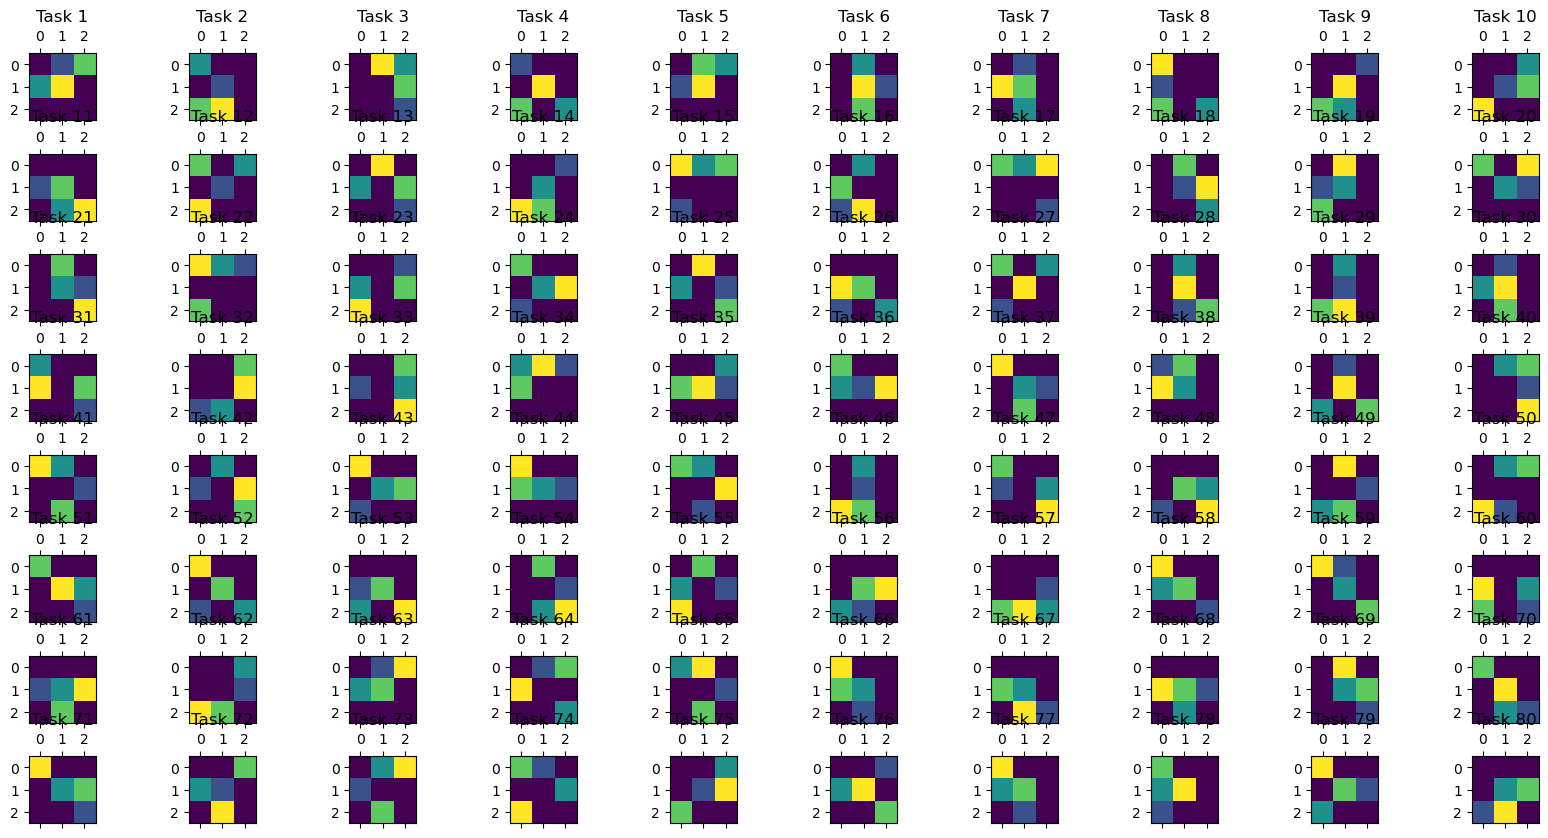

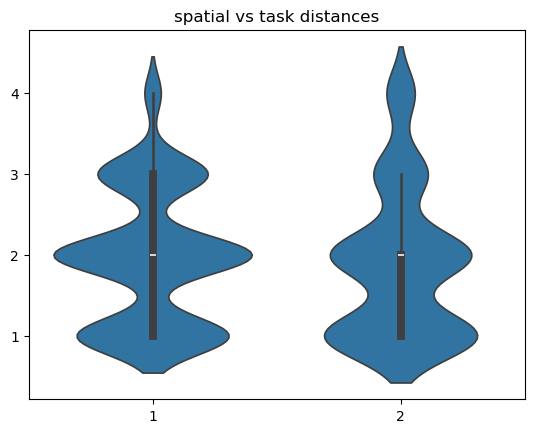

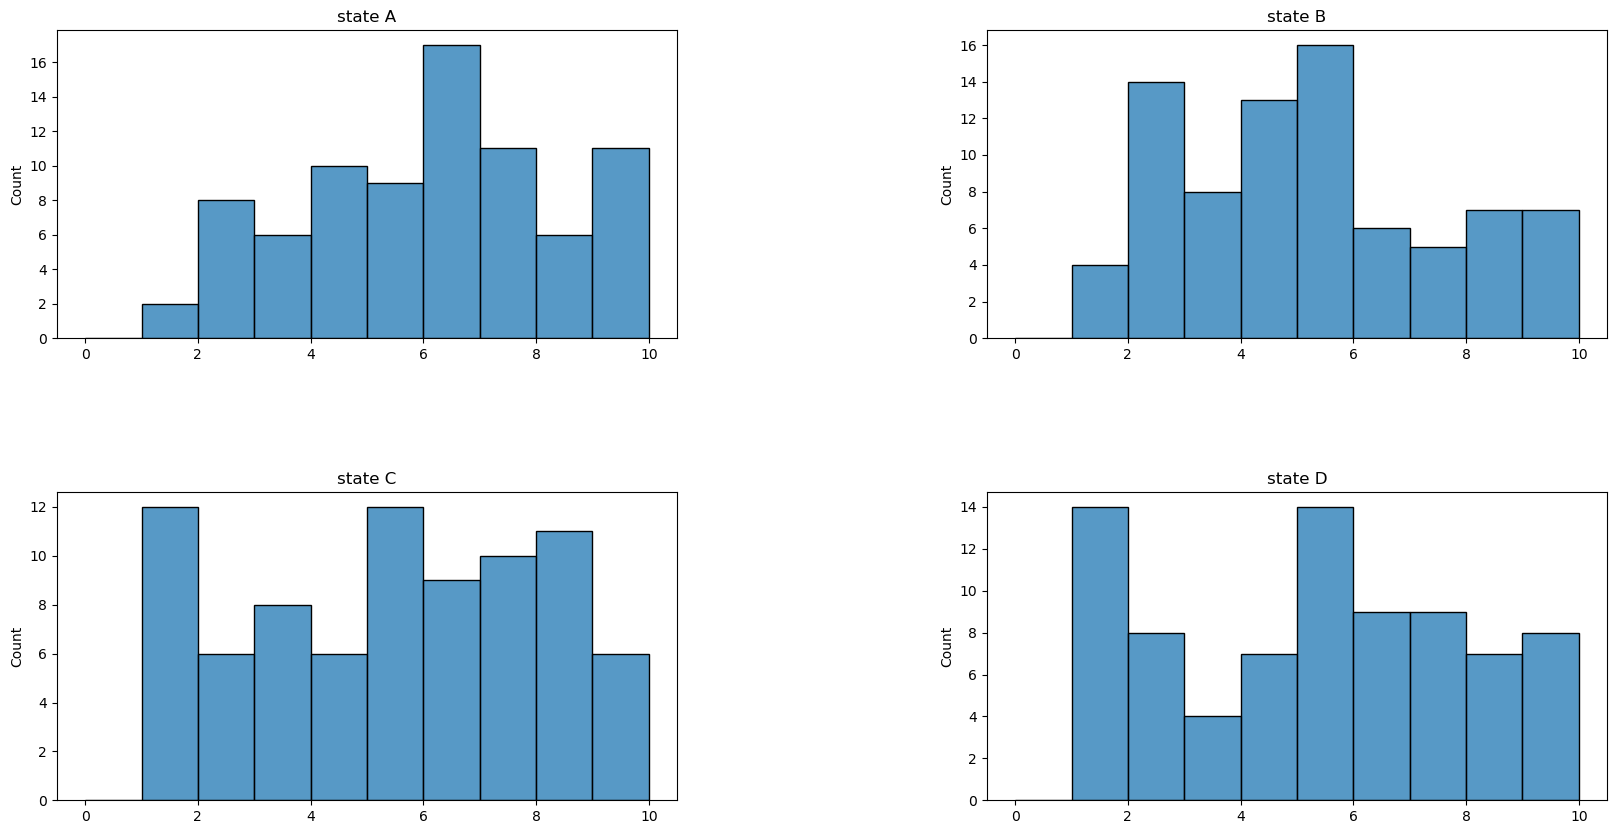

ah09
[[8, 9, 5, 3]]
[[8, 9, 5, 3], [8, 9, 1, 2], [5, 9, 6, 4], [2, 5, 1, 9], [3, 6, 5, 4], [5, 9, 6, 2], [3, 8, 4, 9], [7, 5, 8, 9], [9, 4, 6, 1], [6, 4, 3, 5], [8, 5, 1, 9], [2, 5, 8, 4], [1, 5, 3, 7], [5, 4, 8, 7], [2, 6, 9, 3], [7, 1, 3, 2], [9, 3, 6, 4], [3, 2, 5, 7], [4, 6, 5, 2], [8, 6, 4, 5], [3, 5, 4, 9], [2, 7, 5, 8], [3, 4, 5, 2], [1, 5, 7, 6], [6, 5, 3, 8], [7, 1, 3, 4], [2, 3, 5, 7], [5, 3, 6, 1], [3, 8, 1, 5], [2, 7, 6, 8], [3, 6, 5, 8], [7, 9, 5, 6], [8, 4, 5, 7], [4, 7, 2, 6], [1, 5, 7, 8], [7, 4, 6, 1], [6, 3, 9, 4], [6, 2, 7, 5], [2, 8, 6, 9], [5, 2, 8, 3], [6, 9, 4, 5], [1, 3, 4, 2], [1, 9, 5, 2], [8, 9, 6, 5], [5, 1, 8, 7], [5, 6, 2, 4], [9, 3, 8, 4], [8, 5, 6, 3], [4, 3, 6, 5], [9, 6, 5, 4], [6, 7, 9, 8], [1, 5, 6, 9], [1, 6, 4, 5], [5, 7, 3, 6], [7, 6, 8, 9], [7, 1, 8, 9], [2, 4, 1, 3], [4, 6, 9, 3], [5, 1, 4, 3], [9, 3, 6, 8], [5, 4, 3, 2], [8, 6, 4, 1], [4, 8, 1, 3], [2, 6, 5, 9], [7, 3, 4, 5], [6, 4, 7, 5], [8, 2, 6, 4], [9, 5, 4, 6], [8, 2, 7, 4], [6, 8, 9, 7],

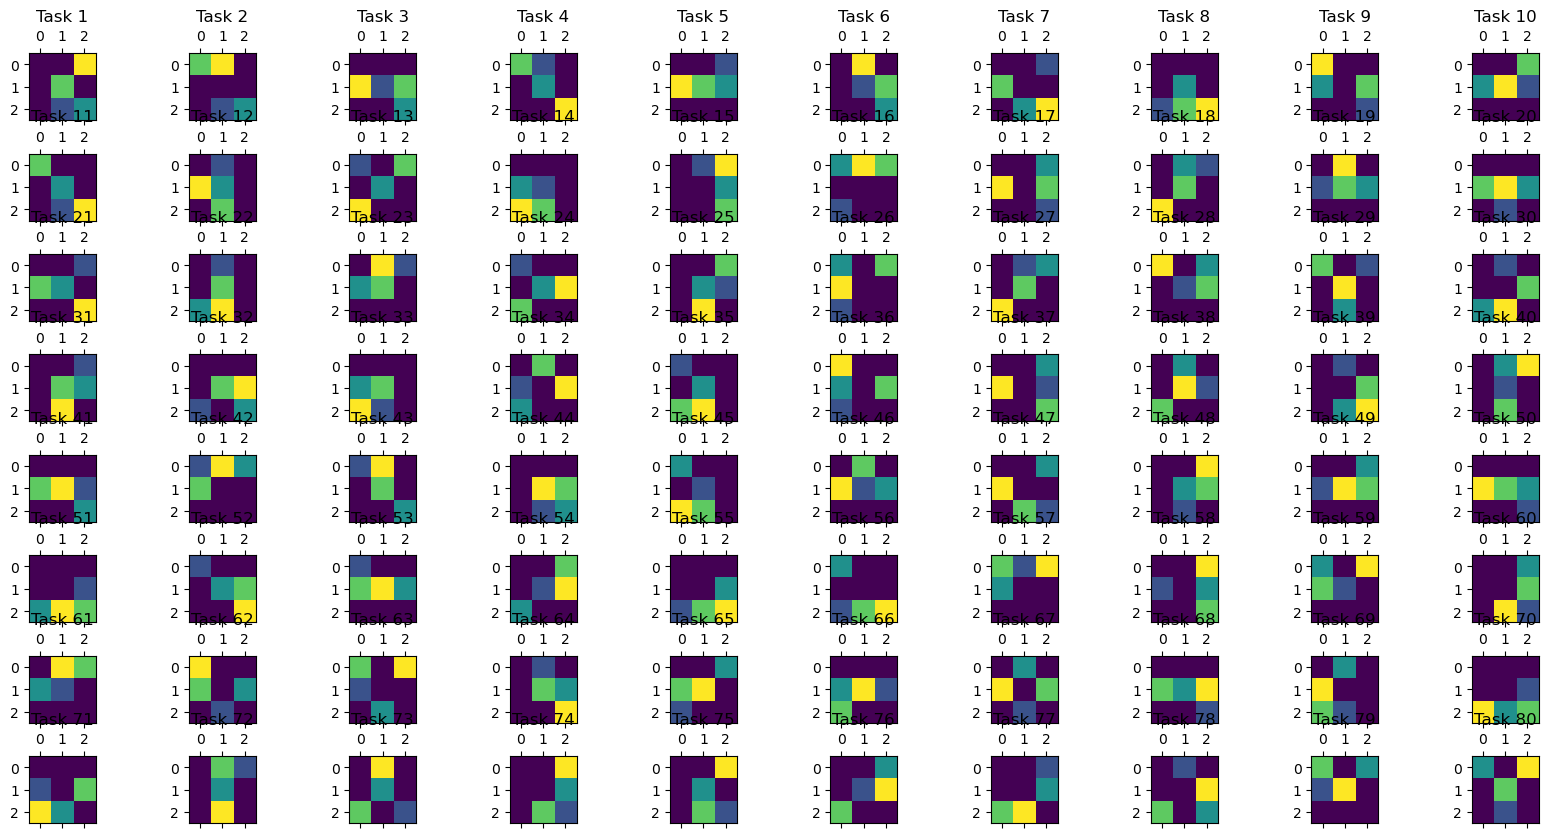

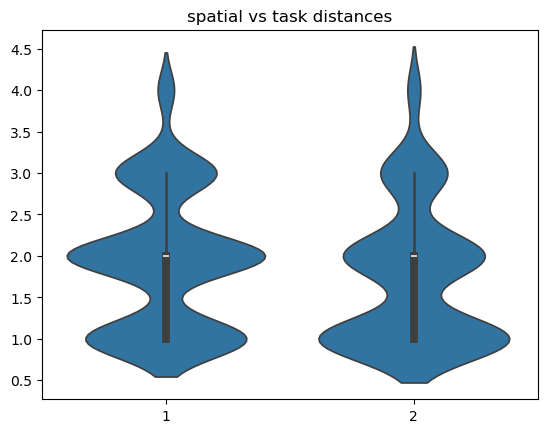

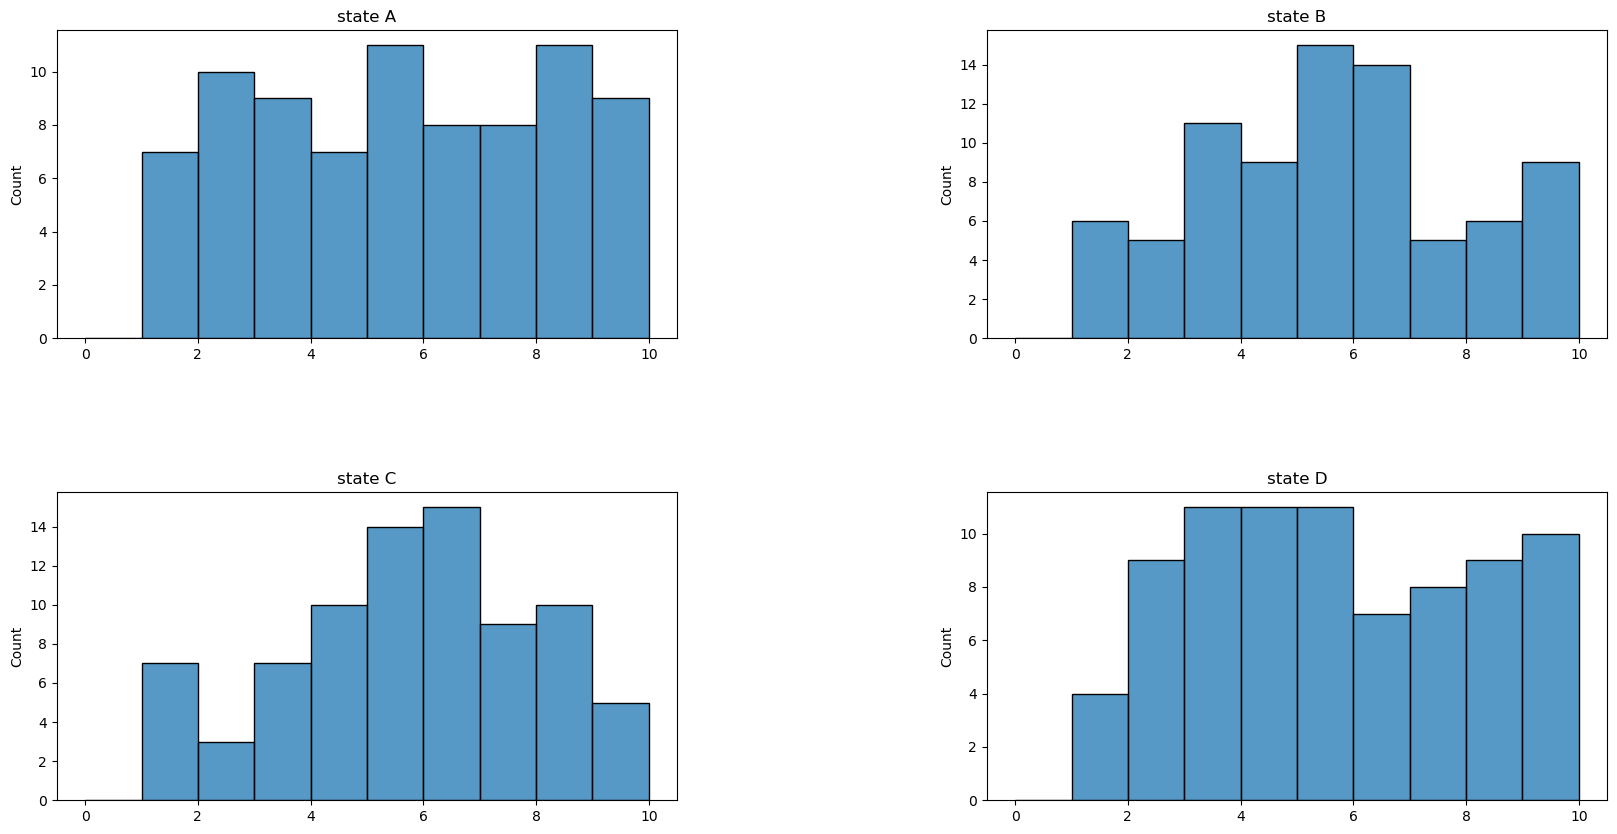

ah10
[[5, 7, 9, 3]]
[[5, 7, 9, 3], [6, 4, 5, 2], [6, 3, 7, 5], [7, 5, 3, 1], [6, 5, 2, 8], [9, 2, 5, 1], [5, 8, 4, 2], [5, 1, 3, 2], [6, 8, 2, 4], [2, 9, 3, 5], [3, 1, 5, 2], [7, 2, 6, 1], [7, 8, 4, 2], [4, 8, 1, 6], [7, 2, 6, 4], [5, 7, 2, 1], [5, 6, 3, 1], [6, 1, 5, 8], [4, 6, 7, 3], [5, 9, 7, 1], [7, 8, 5, 4], [4, 3, 5, 9], [4, 6, 3, 5], [5, 9, 7, 3], [9, 4, 1, 7], [6, 5, 8, 1], [1, 7, 6, 5], [2, 8, 6, 1], [8, 3, 7, 5], [8, 1, 4, 6], [7, 1, 4, 5], [5, 4, 9, 1], [1, 5, 2, 6], [2, 7, 8, 4], [5, 3, 8, 1], [8, 9, 3, 6], [9, 3, 6, 5], [7, 8, 2, 9], [2, 7, 8, 1], [5, 6, 3, 8], [5, 3, 4, 9], [4, 1, 8, 2], [2, 5, 9, 3], [9, 8, 5, 2], [1, 4, 9, 5], [6, 7, 8, 4], [1, 7, 8, 4], [8, 3, 9, 7], [5, 2, 6, 9], [8, 9, 5, 7], [6, 9, 5, 3], [5, 9, 2, 1], [9, 3, 6, 7], [5, 8, 4, 7], [8, 5, 6, 9], [5, 8, 3, 6], [8, 6, 7, 5], [2, 6, 9, 3], [2, 3, 1, 8], [5, 3, 2, 9], [8, 5, 6, 7], [5, 6, 8, 1], [3, 9, 7, 5], [5, 1, 2, 4], [9, 5, 2, 3], [2, 3, 8, 9], [9, 1, 5, 2], [3, 1, 7, 2], [7, 1, 4, 6], [5, 4, 1, 9],

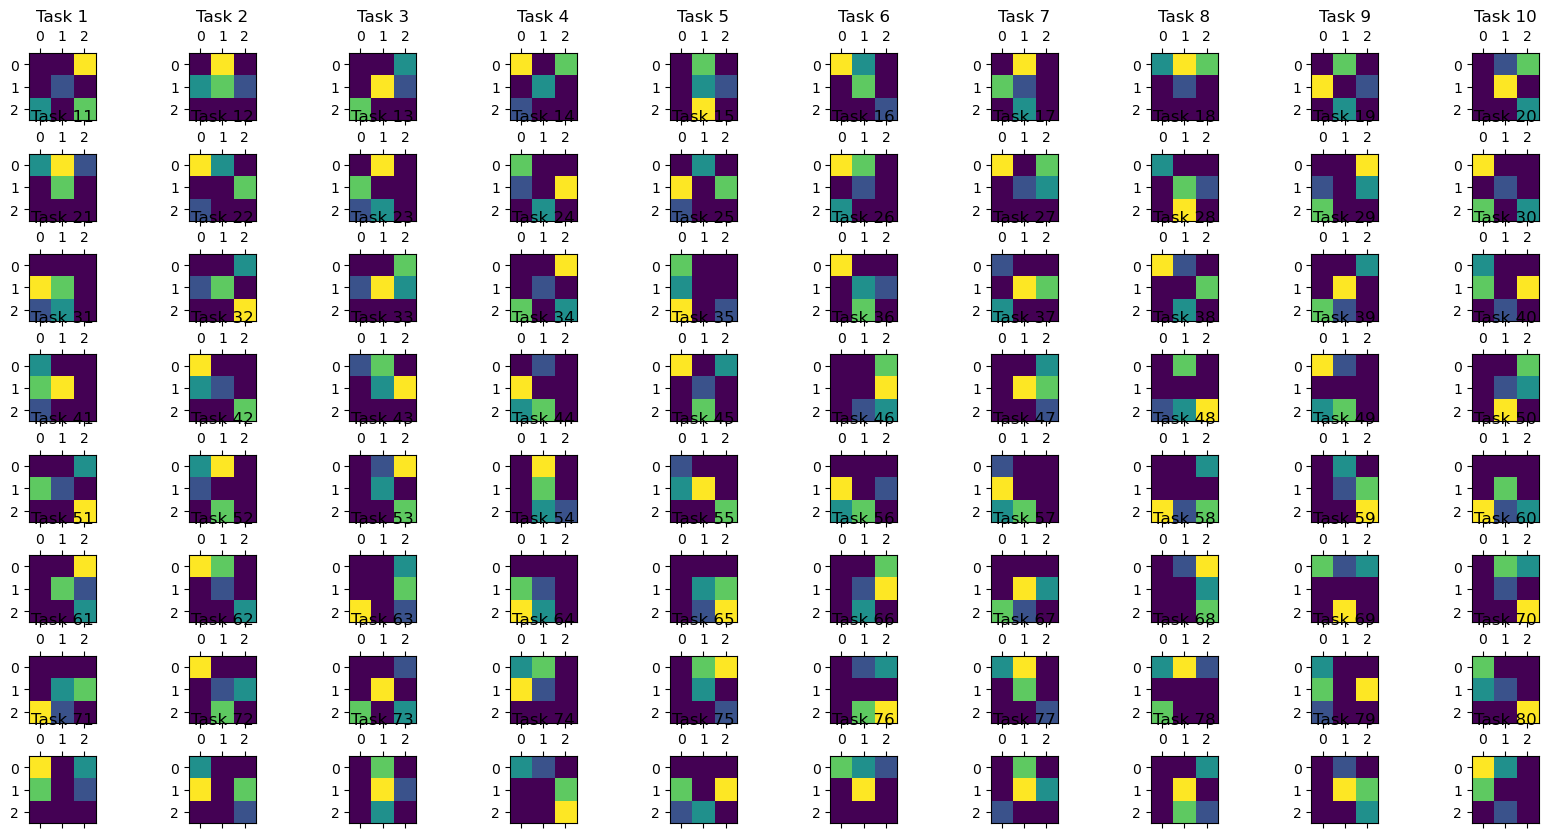

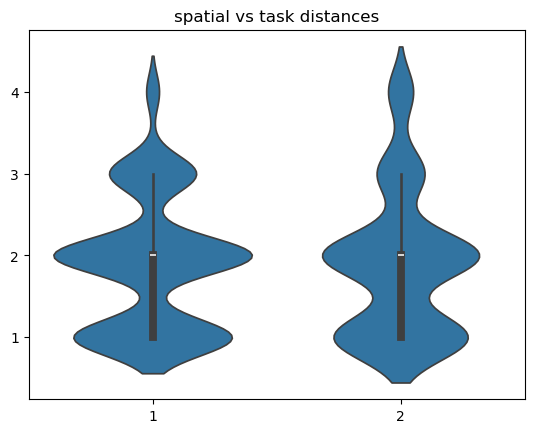

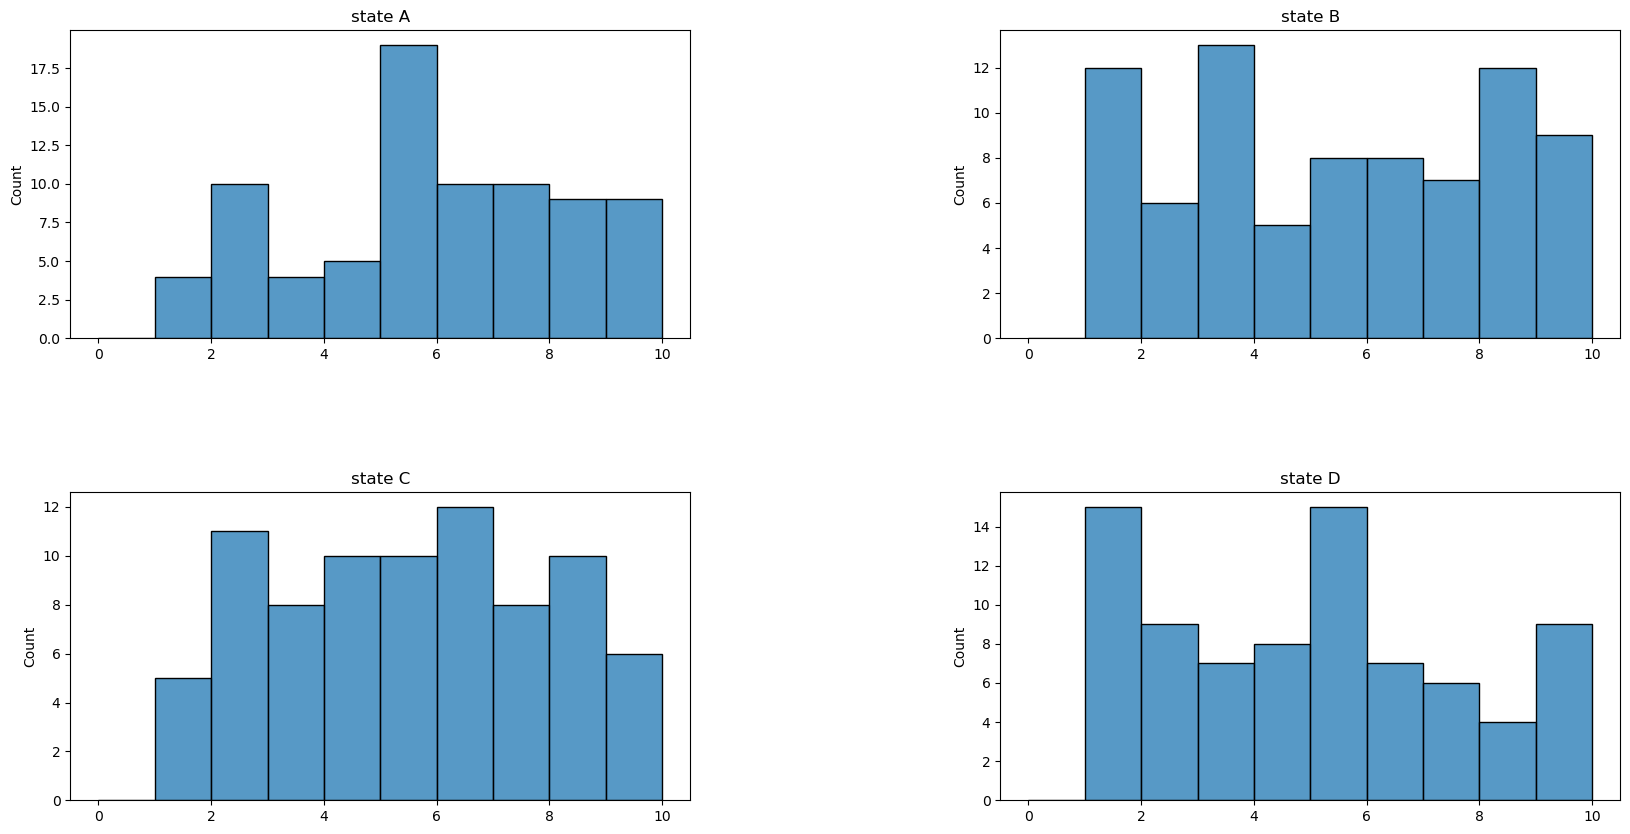

ly05
[[9, 4, 5, 1]]
[[9, 4, 5, 1], [4, 2, 6, 5], [6, 3, 4, 1], [8, 3, 6, 7], [1, 5, 4, 9], [1, 7, 5, 2], [3, 2, 6, 5], [7, 2, 8, 5], [4, 3, 1, 7], [5, 3, 6, 8], [3, 1, 2, 9], [8, 2, 5, 7], [2, 8, 4, 6], [4, 3, 8, 6], [7, 9, 5, 3], [4, 7, 5, 6], [4, 7, 9, 8], [8, 3, 6, 5], [2, 7, 1, 8], [5, 6, 4, 1], [2, 5, 9, 8], [6, 1, 3, 9], [9, 3, 2, 6], [9, 1, 2, 5], [1, 7, 2, 5], [9, 4, 5, 2], [5, 8, 7, 4], [3, 5, 6, 8], [5, 2, 7, 3], [2, 8, 6, 4], [5, 9, 3, 1], [1, 4, 6, 8], [9, 8, 1, 5], [5, 9, 7, 6], [6, 4, 8, 5], [5, 2, 9, 1], [7, 4, 5, 1], [6, 7, 2, 5], [1, 3, 2, 6], [1, 2, 5, 9], [7, 4, 6, 5], [7, 9, 8, 4], [5, 6, 9, 3], [1, 7, 6, 4], [9, 8, 6, 7], [8, 5, 3, 7], [9, 5, 2, 1], [5, 8, 9, 1], [4, 5, 8, 6], [8, 5, 1, 4], [2, 1, 3, 6], [5, 2, 9, 4], [3, 5, 7, 9], [3, 2, 5, 8], [5, 9, 2, 1], [2, 4, 5, 7], [6, 4, 3, 7], [7, 4, 8, 5], [6, 1, 7, 4], [1, 5, 8, 4], [4, 7, 1, 3], [9, 3, 6, 4], [4, 5, 9, 3], [2, 3, 7, 5], [5, 8, 6, 9], [5, 1, 6, 3], [4, 3, 2, 8], [4, 5, 7, 8], [5, 4, 1, 3], [5, 4, 1, 9],

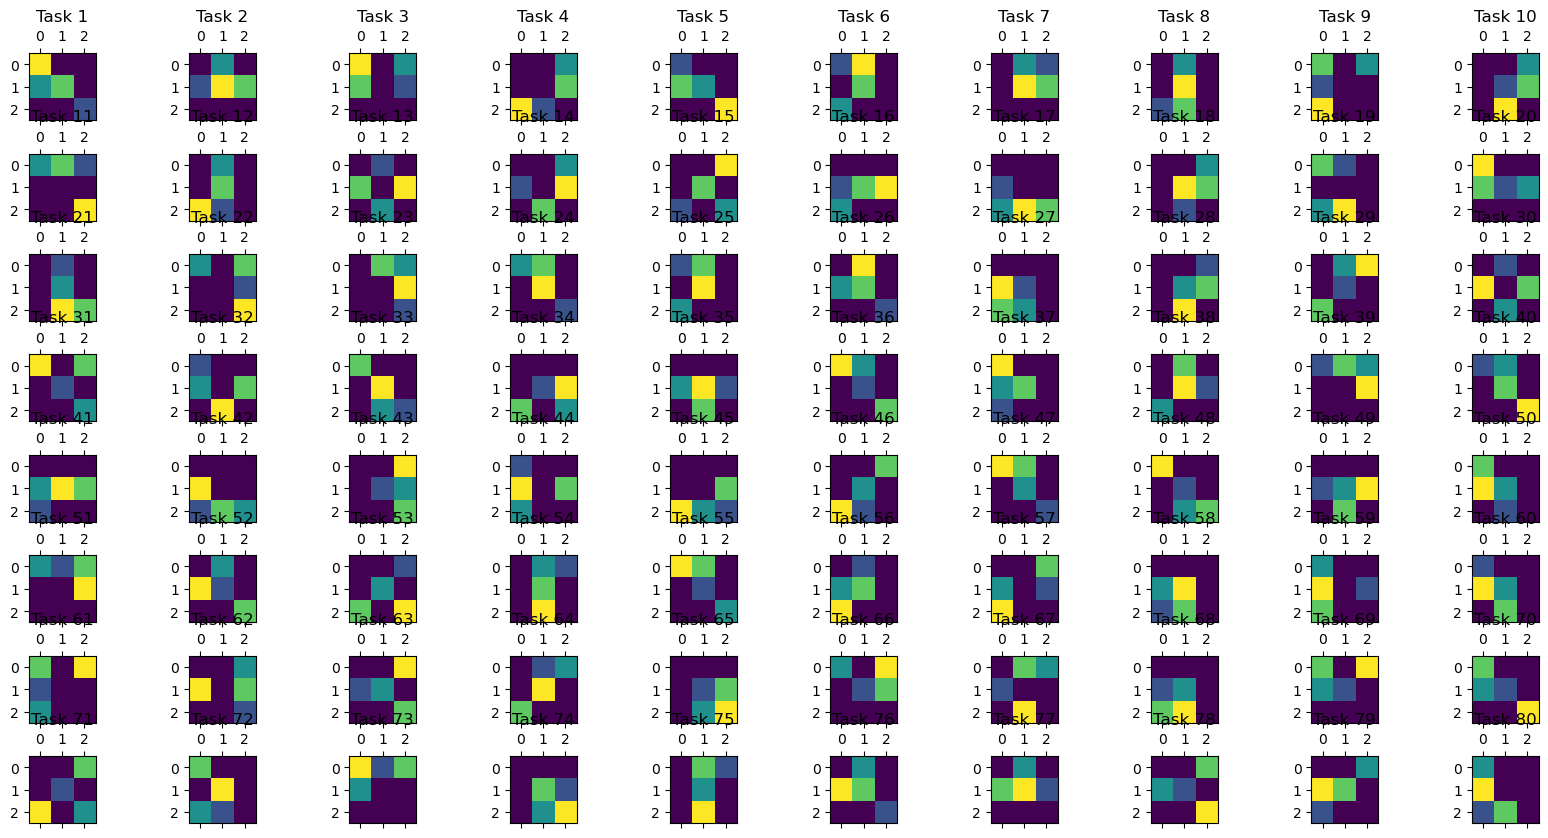

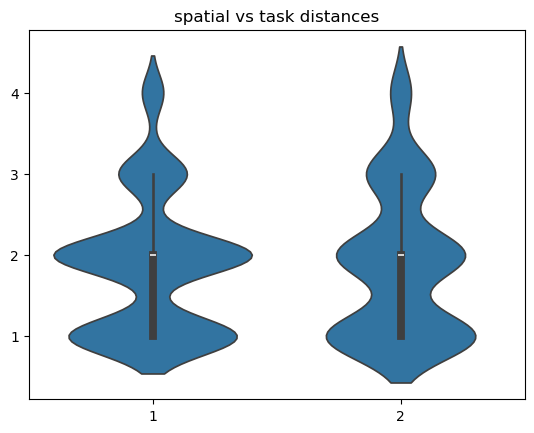

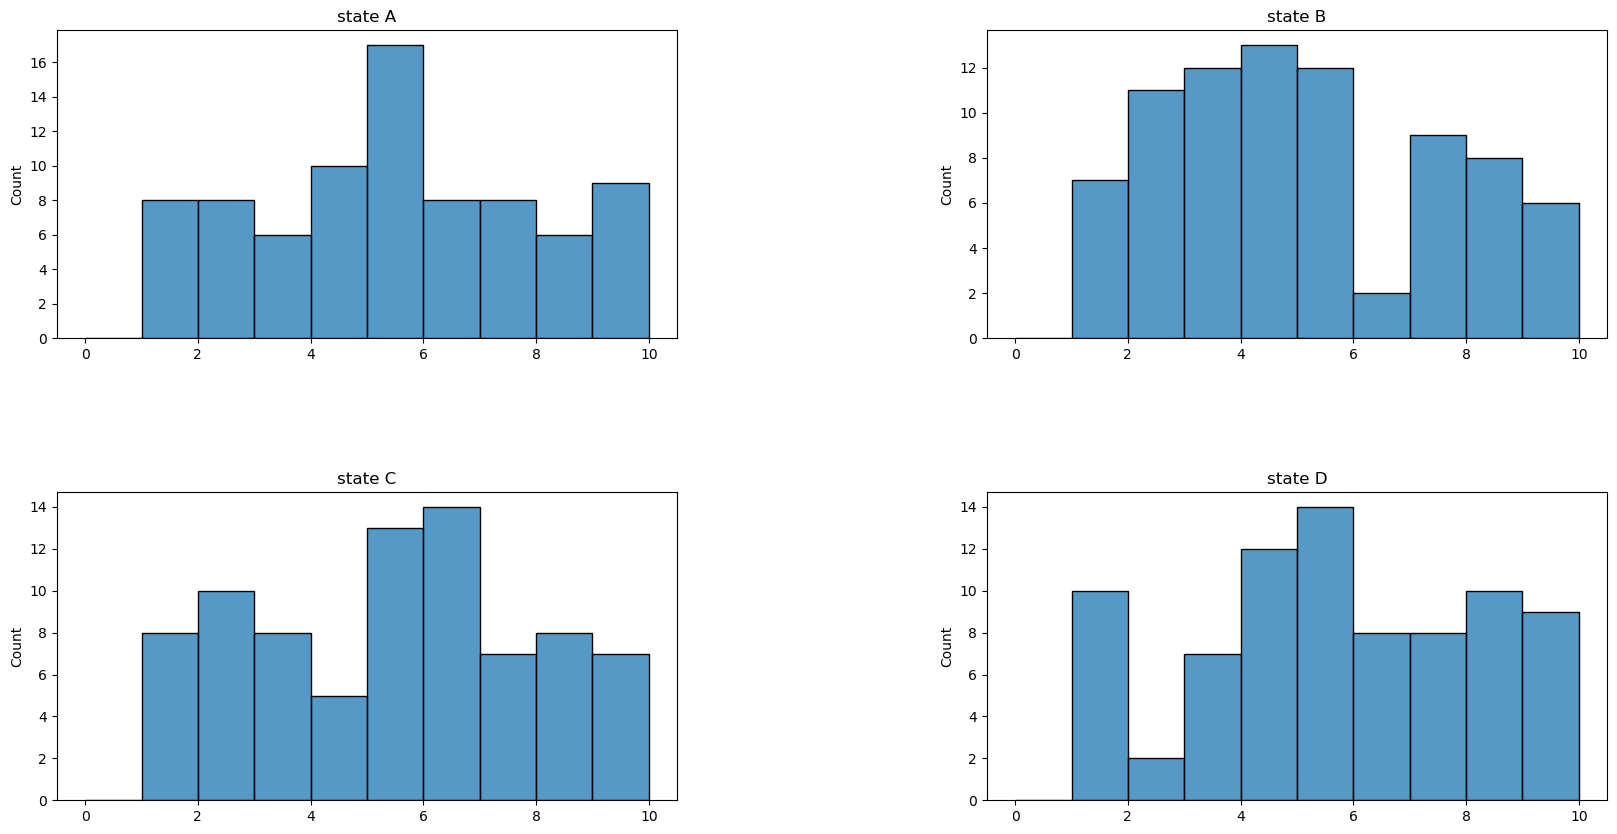

ly06
[[9, 8, 5, 7]]
[[9, 8, 5, 7], [7, 6, 5, 3], [2, 9, 7, 8], [8, 6, 9, 7], [6, 5, 3, 2], [4, 7, 1, 2], [5, 3, 1, 2], [8, 2, 6, 4], [2, 6, 3, 4], [1, 2, 4, 3], [3, 6, 5, 4], [7, 3, 6, 5], [2, 5, 3, 8], [9, 7, 4, 5], [5, 3, 6, 2], [8, 5, 2, 4], [4, 6, 8, 3], [1, 5, 4, 8], [6, 1, 2, 8], [6, 3, 5, 4], [5, 7, 9, 6], [3, 5, 9, 8], [2, 6, 3, 8], [7, 9, 2, 5], [4, 2, 5, 6], [7, 9, 6, 5], [5, 3, 6, 4], [4, 8, 1, 3], [7, 3, 4, 5], [2, 7, 1, 6], [8, 2, 3, 7], [7, 5, 9, 3], [3, 1, 5, 8], [8, 5, 1, 9], [9, 7, 8, 3], [4, 5, 1, 9], [9, 5, 8, 4], [5, 9, 7, 8], [9, 2, 8, 1], [9, 5, 8, 2], [5, 7, 9, 2], [2, 7, 8, 5], [4, 7, 2, 8], [3, 4, 5, 6], [3, 1, 2, 5], [4, 9, 5, 3], [6, 5, 8, 9], [4, 7, 1, 8], [5, 3, 9, 2], [5, 6, 8, 4], [2, 4, 7, 5], [9, 5, 1, 3], [3, 2, 8, 4], [4, 1, 7, 5], [4, 9, 2, 8], [6, 8, 7, 5], [8, 5, 3, 6], [8, 6, 2, 3], [4, 3, 1, 7], [9, 1, 5, 8], [6, 4, 9, 7], [2, 6, 8, 3], [3, 1, 5, 6], [4, 7, 1, 6], [3, 2, 8, 5], [9, 6, 5, 3], [6, 8, 4, 7], [2, 5, 9, 8], [5, 4, 8, 7], [4, 6, 7, 8],

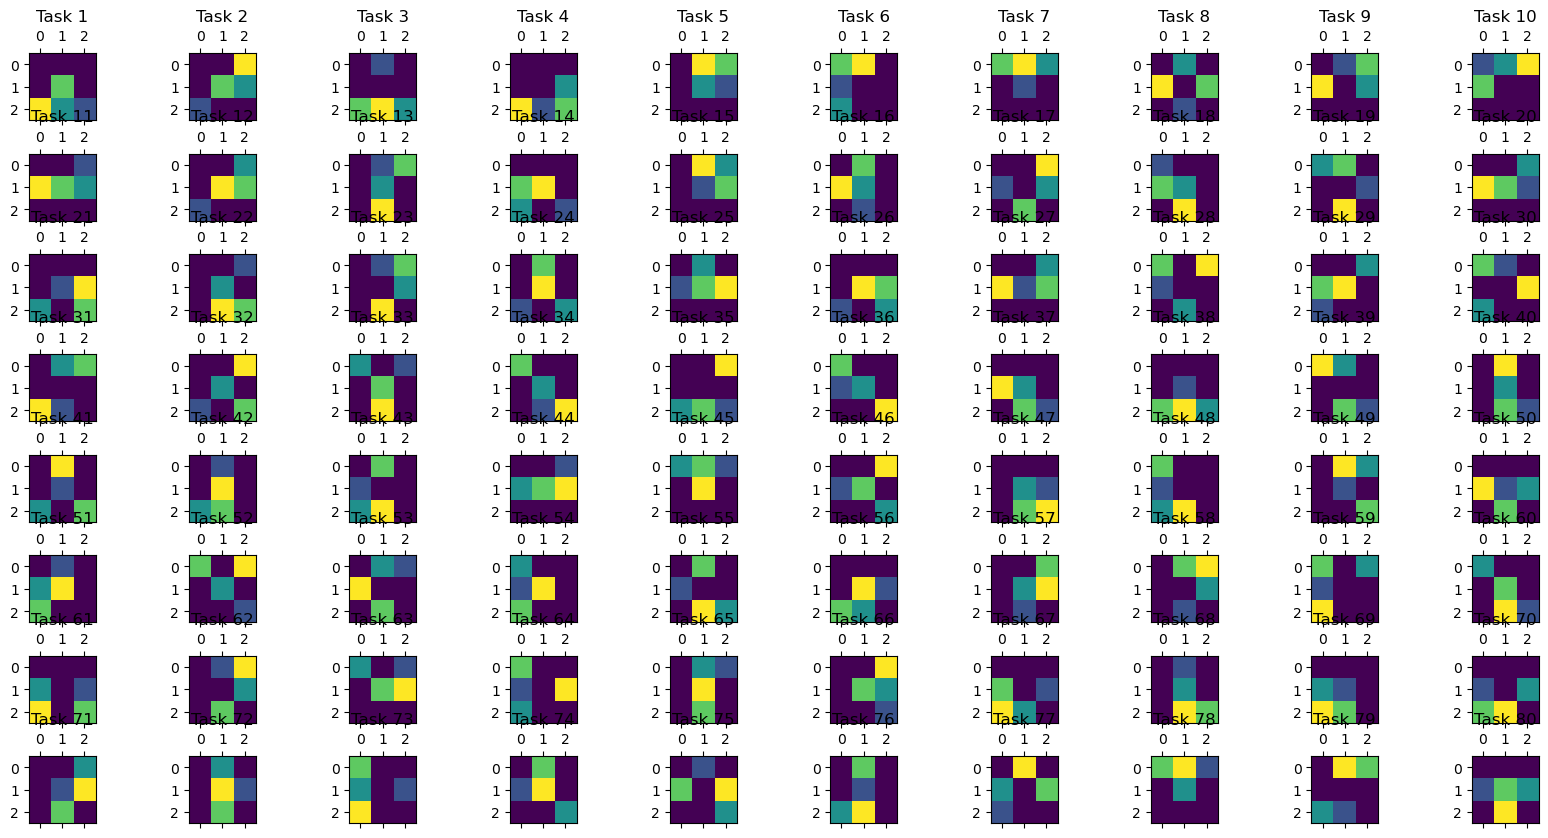

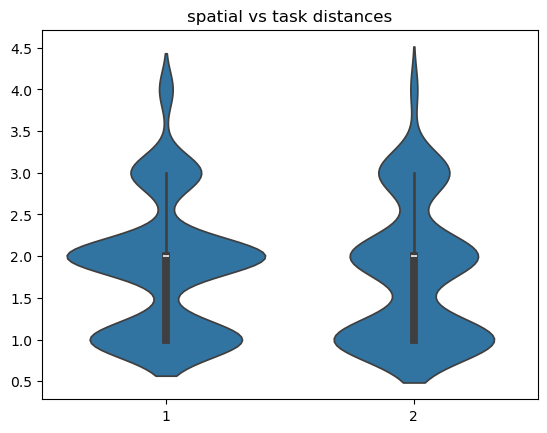

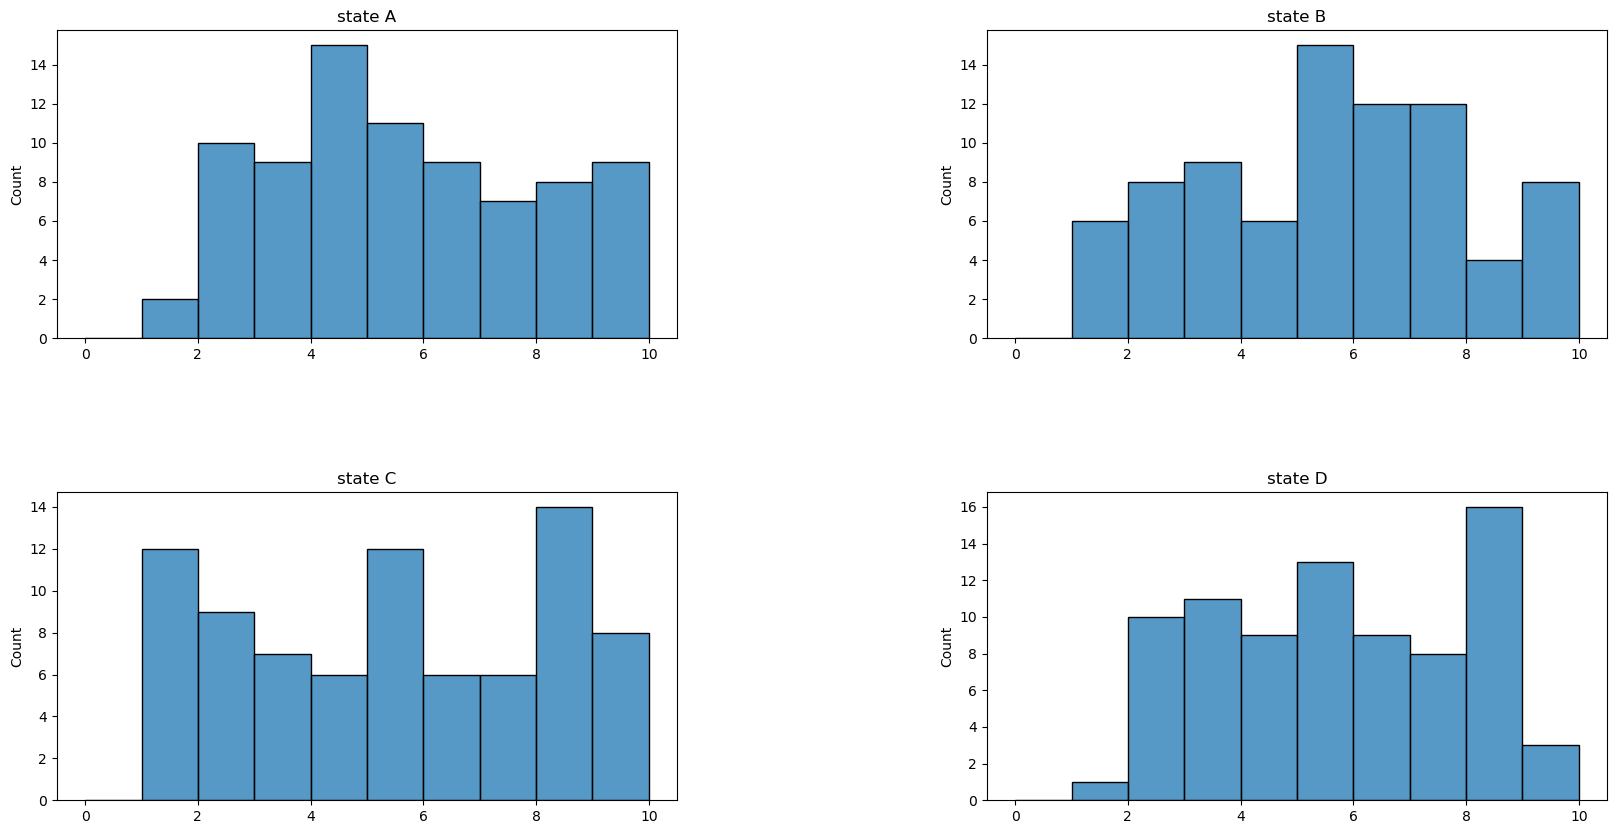

ly07
[[8, 2, 5, 1]]
[[8, 2, 5, 1], [8, 1, 7, 5], [4, 3, 2, 7], [7, 6, 5, 4], [9, 2, 1, 3], [5, 6, 9, 1], [7, 5, 4, 6], [7, 2, 3, 4], [8, 5, 2, 1], [5, 8, 2, 4], [6, 2, 5, 7], [5, 4, 1, 7], [6, 1, 5, 9], [7, 4, 3, 5], [5, 6, 3, 9], [9, 3, 5, 8], [4, 6, 7, 2], [2, 8, 1, 5], [5, 6, 3, 8], [6, 9, 1, 4], [3, 4, 9, 5], [9, 8, 5, 2], [1, 2, 6, 5], [6, 9, 5, 4], [3, 5, 4, 6], [1, 3, 2, 8], [3, 7, 8, 5], [7, 9, 4, 5], [8, 5, 1, 6], [4, 1, 9, 5], [3, 4, 6, 1], [8, 6, 9, 4], [6, 7, 8, 5], [8, 2, 9, 7], [5, 3, 1, 4], [9, 2, 4, 6], [7, 5, 2, 9], [8, 5, 7, 2], [2, 8, 6, 1], [4, 8, 5, 7], [7, 8, 2, 6], [5, 3, 6, 2], [8, 7, 6, 4], [4, 6, 8, 5], [9, 3, 8, 6], [2, 6, 4, 8], [3, 9, 5, 2], [5, 7, 4, 6], [8, 6, 5, 3], [6, 7, 5, 3], [1, 4, 5, 9], [6, 7, 5, 8], [4, 8, 6, 9], [7, 5, 8, 3], [3, 9, 7, 8], [3, 6, 1, 4], [7, 4, 8, 6], [2, 3, 5, 6], [9, 2, 6, 5], [3, 9, 5, 8], [7, 5, 2, 4], [3, 8, 5, 4], [5, 3, 8, 1], [8, 9, 2, 5], [6, 5, 1, 2], [3, 5, 6, 8], [8, 3, 2, 9], [1, 4, 3, 6], [9, 1, 2, 5], [8, 3, 6, 7],

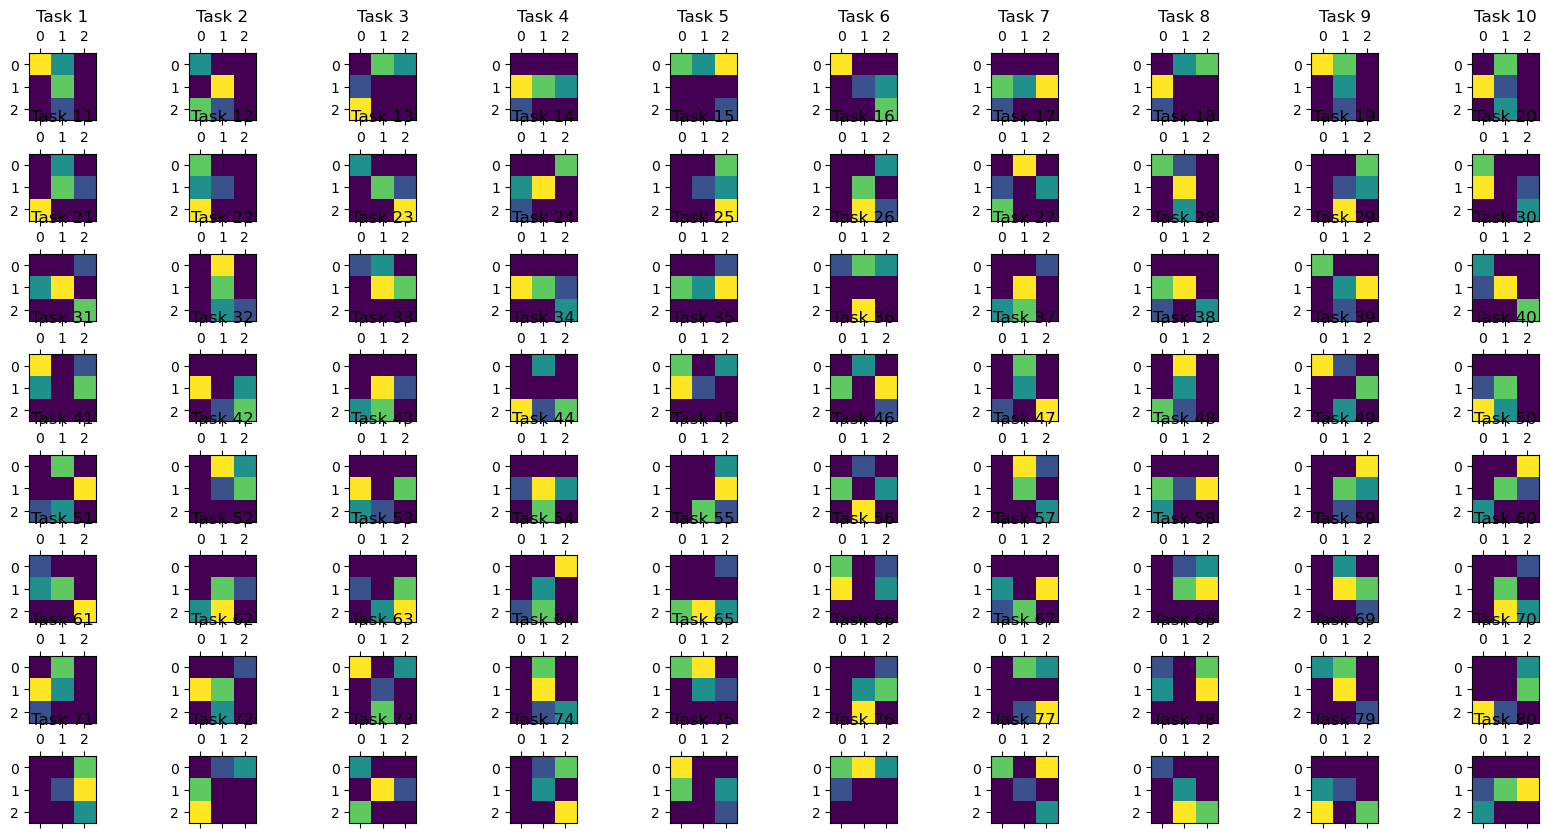

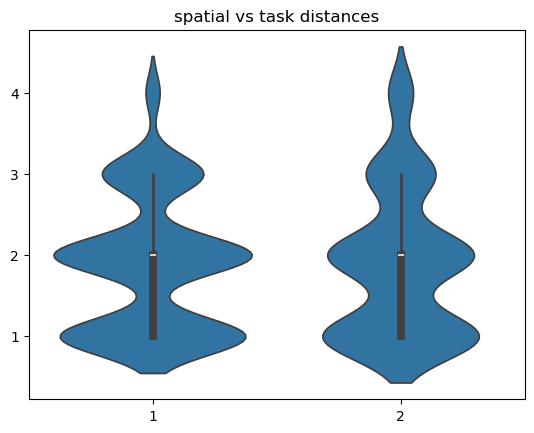

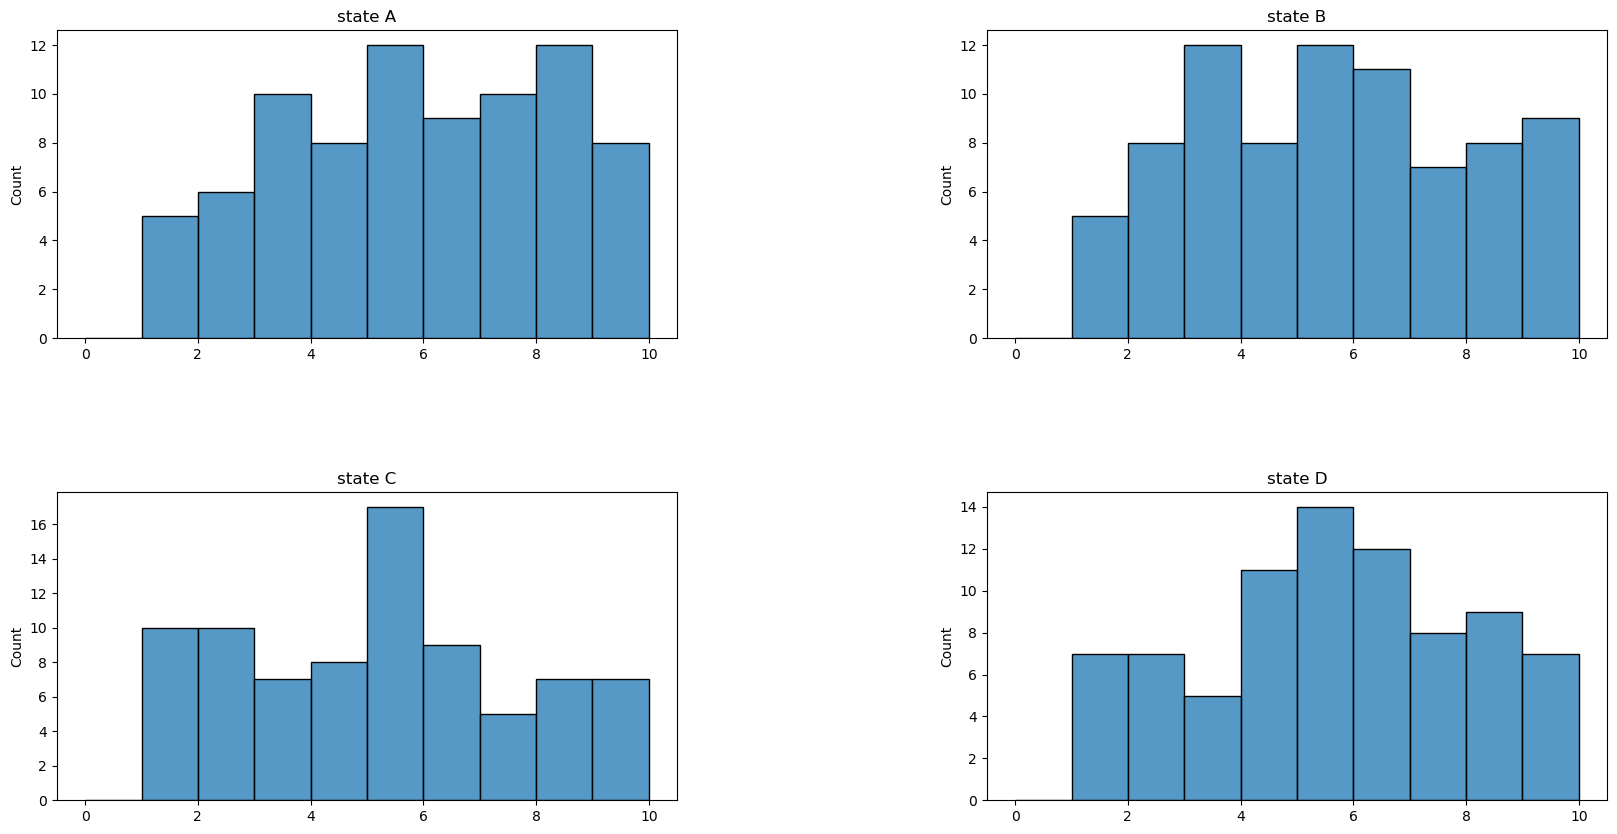

In [ ]:
mice = ['ah08','ah09','ah10','ly05','ly06','ly07']


seed_tasks = [[2,4,3,5],
                [8,9,5,3],
                [5,7,9,3],
                [9,4,5,1],
                [9,8,5,7],
                [8,2,5,1]]

savepath = r'/Users/AdamHarris/Desktop/cohort10_tasks/'
num_tasks = 80
num_must_inc_5 = 1
for counter, mouse in enumerate(mice):
    print(mouse)
    seed = [seed_tasks[counter]]

    tasks = task_generator(num_tasks, num_must_inc_5, seed)
    print(tasks)
    
    now_ = datetime.now()
    now = now_.strftime("%d_%m_%Y_time%H_%M_%S")
    with open(savepath+mouse+'_tasks_'+now+'.txt','w',newline='') as fou:
        cw = csv.writer(fou)
        cw.writerows(tasks)


    fig, axs = plt.subplots(int(num_tasks / 10), 10, figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.5, wspace=0.5)

    axs = axs.ravel()

    for i in range(len(tasks)):

        axs[i].matshow(list_to_mat(tasks[i]))
        axs[i].set_title(f'Task {i+1}')

    fig.savefig(savepath+mouse+'_tasks_'+now+'.pdf')
    plt.show()

    s, t = distances(tasks)

    fig, ax = plt.subplots()
    sns.violinplot(x=t, y=s)


    plt.title('spatial vs task distances')
    fig.savefig(savepath+mouse+'_distances_'+now+'.pdf')
    plt.show()

    # sns.regplot(x=t, y=s)
    # plt.show()

    fig, axs = plt.subplots(2, 2, figsize=(20, 10), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace=.5, wspace=0.5)

    axs = axs.ravel()

    states = ["A", "B", "C", "D"]

    for i in range(len(tasks[0])):

        sns.histplot(np.array(tasks)[:, i], kde=False, ax=axs[i], bins=np.arange(0, 11))
        axs[i].set_title(f'state {states[i]}')
    fig.savefig(savepath+mouse+'_distributions_'+now+'.pdf')
    plt.show()




d = savepath
# Get all txt files in the directory
txt_files = glob.glob(os.path.join(d, '*.txt'))

# Initialize a dictionary to hold the sequences for each subject
sequences_dict = {}

# Read each file and store the sequences
for file in txt_files:
    subject_id = os.path.basename(file)[:4]
    with open(file, 'r') as f:
        sequences = [line.strip() for line in f.readlines()]
        sequences_dict[subject_id] = sequences

# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(sequences_dict, orient='index').transpose()


# Sort the columns alphabetically
df = df.sort_index(axis=1)
# Add a column for 'sequence number'
df.insert(0, 'task num', range(1, len(df) + 1))

# Save the DataFrame to a CSV file
df.to_csv(os.path.join(d, 'cohort10_tasks.csv'), index=False)

In [ ]:
degen_types

[0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 0,
 0,
 2,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 2,
 2,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 2,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 0,
 1,
 1,
 1,
 2,
 0,
 2,
 2,
 1,
 1,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 2,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 1,
 2,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 1,
 0,
 1,
 2,
 1,
 1,
 2,


# checking distribution of degenerate solutions

In [ ]:

def degenerate_solutions_type_checker(sample):
    transitions_task = [str(sample[i % len(sample)]) + str(sample[(i + 1) % len(sample)]) for i in range(len(sample))]
    # print(transitions_task)

    # check clockwise solutions

    """
    IVE ADDED [0] TO TO THECLOCKWISE AND ANTICLOCKWISE LOOPS
    SO THAT THE ONLY DEGENERATE SOLUTIONS ARE OUTER LOOPS NOT SUBLOOPS
    """

    for counter, i in enumerate(clockwise_loops.values()):
        bool_arr = np.zeros((len(sample),))
        if all([str(item) in i for item in sample]):
            #print(i + " ALL")
            for ind, transition in enumerate(transitions_task):
                degen_dist = (i.find(transition[1]) - i.find(transition[0])) % len(i)
                optimal_dist = mindistance_mat[int(transition[0]) - 1, int(transition[1]) - 1]
                #print("clockwise", transition, degen_dist, optimal_dist, degen_dist == optimal_dist)
                if degen_dist == optimal_dist:
                    bool_arr[ind] = 1
            if sum(bool_arr) / len(sample) >= 0.75:
                return 1 if counter == 0 else 2

    # check anticlockwise solutions

    for counter, i in enumerate(anticlockwise_loops.values()):
        bool_arr = np.zeros((len(sample),))
        if all([str(item) in i for item in sample]):
            #print(i + " ALL")
            for ind, transition in enumerate(transitions_task):
                degen_dist = (i.find(transition[1]) - i.find(transition[0])) % len(i)
                optimal_dist = mindistance_mat[int(transition[0]) - 1, int(transition[1]) - 1]
                #print("anticlockwise", transition, degen_dist, optimal_dist, degen_dist == optimal_dist)
                if degen_dist == optimal_dist:
                    bool_arr[ind] = 1
            if sum(bool_arr) / len(sample) >= 0.75:
                return 1 if counter == 0 else 2 

    return 0


def sample_nodes_degen_checker(num, inc_5, tasks):
    sample = random.sample(list(range(1, 10)), num)
    # print(sample)
    if inc_5:
        if 5 not in sample:
            sample = sample_nodes(num, inc_5, tasks)
            return sample 
    if sample in tasks:
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
    if check_transitions(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample
    if check_nodes(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample
    if check_rotations(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
    if check_task_roll(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
    if check_nodes_in_state(sample, tasks):
        sample = sample_nodes(num, inc_5, tasks)
        return sample 
        
    degen_type = degenerate_solutions_type_checker(sample)

    return sample, degen_type

# generates task and spatial distances for each transition in each task to check they are uncorraleted



# main function
def task_generator(num, node_5_extent, seed):
    tasks = seed
    offset = len(tasks)
    degen_types = []
    for i in range(num - offset):
        task_i, degen_type = sample_nodes_degen_checker(4, i < (node_5_extent - offset), tasks)
        #print(f'added task {task_i}')
        tasks.append(task_i)
        degen_types.append(degen_type)

    return tasks, degen_types

In [29]:
tasks, degen_types = task_generator(500, 0, [])

# Find example tasks where degen_types == 1
tasks_degen_1 = [tasks[i] for i in range(len(degen_types)) if degen_types[i] == 1]

# Find example tasks where degen_types == 2
tasks_degen_2 = [tasks[i] for i in range(len(degen_types)) if degen_types[i] == 2]

print("Example tasks where degen_types == 1:")
print(tasks_degen_1[:5])  # Print first 5 examples

print("\nExample tasks where degen_types == 2:")
print(tasks_degen_2[:5])  # Print first 5 examples

Example tasks where degen_types == 1:
[[9, 2, 6, 1], [1, 4, 9, 3], [7, 3, 9, 2], [9, 6, 2, 1], [2, 7, 8, 9]]

Example tasks where degen_types == 2:
[[3, 1, 6, 2], [7, 9, 5, 4], [5, 2, 3, 8], [8, 7, 5, 4], [6, 7, 8, 4]]


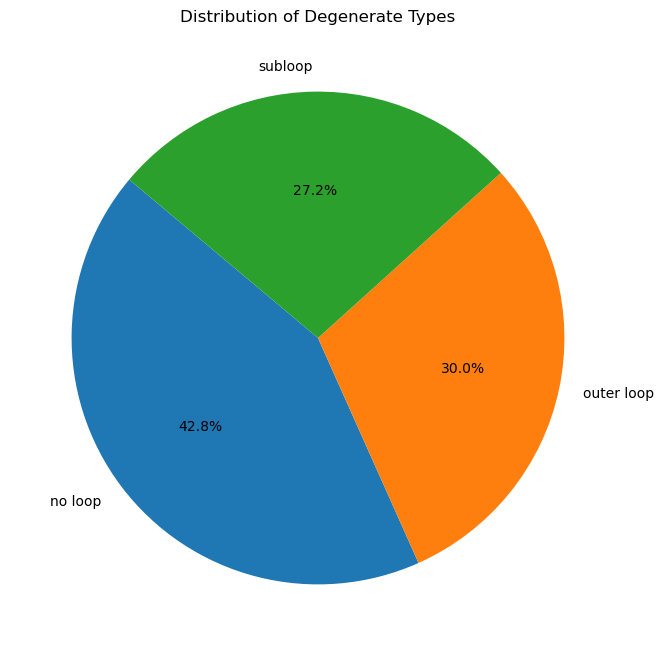

In [30]:
# Count the occurrences of each type in degen_types
degen_counts = [degen_types.count(i) for i in set(degen_types)]

# Labels for the pie chart
labels = ['no loop', 'outer loop', 'subloop']

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(degen_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Degenerate Types')
plt.show()

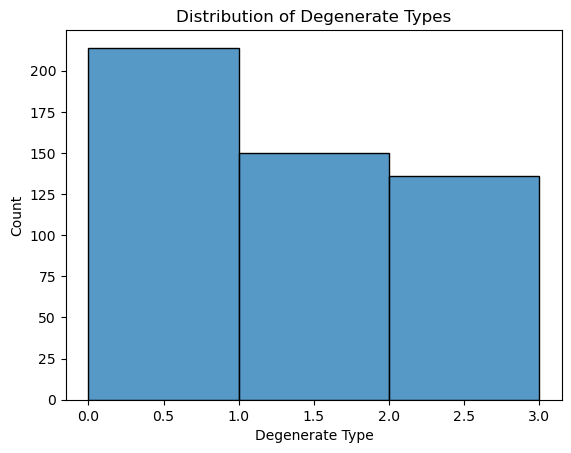

In [34]:
sns.histplot(degen_types, kde=False, bins=range(4))
plt.xlabel('Degenerate Type')
plt.ylabel('Count')
plt.title('Distribution of Degenerate Types')
plt.show()